# Characterizing perturbation of cellular transcriptomes due to RNA exporter expression

# Introduction

## Imports

In [1]:
import sys
import os
import time

import numpy as np
import scipy
import pandas as pd

%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns

## Set output parameters

In [2]:
# Set pandas display options
pd.set_option('display.max_rows', 30)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)

# Set plot display options
FONTSIZE = 8  # universal fontsize
params = {
    'font.size': FONTSIZE,
    'axes.titlesize': FONTSIZE,
    'axes.labelsize': FONTSIZE,
    'legend.fontsize': FONTSIZE,
    'xtick.labelsize': FONTSIZE,
    'ytick.labelsize': FONTSIZE,
    'font.family': "Helvetica",
    'mathtext.fontset': 'custom',
    'pdf.fonttype': 42,
    'ps.fonttype': 42,
    'figure.dpi': 300
   }
mpl.rcParams.update(params)
sns.set_style("ticks", {'axes.grid' : False})

# Set plot output options
output_dir = "outs/transcriptome_stress"
output_suffix = ""
output_formats = [".png", ".pdf"]

mpl.rc('savefig', dpi=300)

# Define convenience function for saving figures

savefig = True
savefig_args = {"dpi": 300, "bbox_inches": "tight", "pad_inches": 0.1}

def save_figure(fig, name, output_dir=output_dir, output_suffix=output_suffix, output_formats=output_formats, savefig_args=savefig_args):
    if savefig:
        for output_format in output_formats:
            fig.savefig(output_dir + "/" + name + output_suffix + output_format, **savefig_args)
    return None

In [3]:
# Report plot parameters
sns.plotting_context()

{'font.size': 8.0,
 'axes.labelsize': 8.0,
 'axes.titlesize': 8.0,
 'xtick.labelsize': 8.0,
 'ytick.labelsize': 8.0,
 'legend.fontsize': 8.0,
 'legend.title_fontsize': None,
 'axes.linewidth': 0.8,
 'grid.linewidth': 0.8,
 'lines.linewidth': 1.5,
 'lines.markersize': 6.0,
 'patch.linewidth': 1.0,
 'xtick.major.width': 0.8,
 'ytick.major.width': 0.8,
 'xtick.minor.width': 0.6,
 'ytick.minor.width': 0.6,
 'xtick.major.size': 3.5,
 'ytick.major.size': 3.5,
 'xtick.minor.size': 2.0,
 'ytick.minor.size': 2.0}

# Load data

## Load read counts

In [4]:
# Load read counts

infile = "../preprocessed_data/transcriptome_data/transcriptomics_cell/htseq.tab"

counts_raw = pd.read_csv(infile, sep="\t", header=0, index_col=0)

print(counts_raw.shape)
counts_raw.head()

(60766, 8)


,L220420_1,L220420_2,L220420_3,L220420_4,L220420_5,L220420_6,L220420_7,L220420_8
symbol,,,,,,,,
EGFP,198592,98788,93438,62364,0,0,0,0
ENSG00000000003,2691,2615,2802,2800,2464,3358,3184,2991
ENSG00000000005,7,2,8,7,5,8,10,11
ENSG00000000419,1514,1543,1533,1536,1263,1936,1291,1139
ENSG00000000457,535,614,653,625,522,686,614,557


In [5]:
# Load mapping statistics

infile = "../preprocessed_data/transcriptome_data/transcriptomics_cell/STAR.tab"

star_raw = pd.read_csv(infile, sep="\t", header=0, index_col=0)

print(star_raw.shape)
star_raw.head()

(8, 6)


,input,uniquely_mapped,multiple_loci,too_many_loci,percent_unmapped_too_many_mismatches,percent_unmapped_too_short
name,,,,,,
L220420_1,29963299,27685662,779784,1709,0.00%,4.89%
L220420_2,30128511,28122430,753757,1678,0.00%,4.05%
L220420_3,32130108,29744539,838508,1889,0.00%,4.71%
L220420_4,30889272,29110999,764261,1526,0.00%,3.18%
L220420_5,24751627,23159223,625418,1401,0.00%,3.80%


## Load additional resources

In [6]:
# Load ERCC gene names

infile = "../resources/names_ERCC92.txt"

names_ERCC = []
with open(infile) as f:
    for line in f:
        names_ERCC.append(line.rstrip())
print("Loaded", len(names_ERCC), "gene names")

Loaded 92 gene names


## Specify sample information (names, colors)

In [7]:
# Set transgene names
names_transgenes = ["EGFP", "mCherry", "mTagBFP2"]

In [8]:
# Set gene colors
gene_to_color = {"mCherry": "#dc2a24", "EGFP": "#6f69a0", "mTagBFP2": "#9b9d9f"}

# Set gene markers
gene_to_marker = {"mCherry": "*", "EGFP": "s", "mTagBFP2": "o"}

In [9]:
# Set sample labels (more descriptive names)
col_to_sample = {"L220420_1": "MMLV_Gag",
                 "L220420_2": "Gag-MCP",
                 "L220420_3": "GagZip-MCP",
                 "L220420_4": "EPN24-MCP",
                 "L220420_5": "No_Exporter_Psi", 
                 "L220420_6": "No_Exporter_MS2x8",
                 "L220420_7": "No_DNA",
                 "L220420_8": "No_Transfection"}

# Set sample colors
col_to_color = {"L220420_1": "#3c955b",
                 "L220420_2": "#a29fc2",
                 "L220420_3": "#7b74aa",
                 "L220420_4": "#563583",
                 "L220420_5": "#fcd0a2", 
                 "L220420_6": "#f68c3f",
                 "L220420_7": "#8a8c8f",
                 "L220420_8": "#c5c6c8"}

# Convert to map from sample label to color
sample_to_color = {v: col_to_color[k] for k, v in col_to_sample.items()}


# Preprocess data

## Rename samples with more informative names

In [10]:
counts_raw = counts_raw.rename(mapper=col_to_sample, axis=1)
star_raw = star_raw.rename(mapper=col_to_sample, axis=0)

## Convert gene names from Ensembl to symbol

In [11]:
# Convert gene names from Ensembl to symbols (actually symbol underscore Ensembl ID)
df_ensembleToSymbol = pd.read_csv("../resources/Ensembl_to_symbol.csv", header=0, index_col=0, sep=",")
counts_raw["symbol_ensembl"] = df_ensembleToSymbol.loc[counts_raw.index]["symbol_ensembl"]
counts_raw.set_index("symbol_ensembl", inplace=True)

## Drop genes that are never observed

In [12]:
print(np.sum(counts_raw.sum(axis=1) == 0), "genes are never observed (count = 0 for all samples)")
print(np.mean(counts_raw.sum(axis=1) == 0)*100, "% of genes are never observed (count = 0 for all samples)")

29978 genes are never observed (count = 0 for all samples)
49.33350887009183 % of genes are never observed (count = 0 for all samples)


In [13]:
names_unmapped = ['__no_feature', '__ambiguous', '__too_low_aQual', '__not_aligned', '__alignment_not_unique']

names_not_observed = counts_raw.loc[counts_raw.sum(axis=1) == 0].index  # names of genes that were never observed
names_not_observed_clean = list(set(names_not_observed) - set(names_unmapped + names_ERCC + names_transgenes))  # remove names of special genes that we want to keep

counts_raw = counts_raw.drop(names_not_observed_clean)  # drop genes

print(counts_raw.shape)
counts_raw.head()

(30882, 8)


,MMLV_Gag,Gag-MCP,GagZip-MCP,EPN24-MCP,No_Exporter_Psi,No_Exporter_MS2x8,No_DNA,No_Transfection
symbol_ensembl,,,,,,,,
EGFP,198592,98788,93438,62364,0,0,0,0
TSPAN6_ENSG00000000003,2691,2615,2802,2800,2464,3358,3184,2991
TNMD_ENSG00000000005,7,2,8,7,5,8,10,11
DPM1_ENSG00000000419,1514,1543,1533,1536,1263,1936,1291,1139
SCYL3_ENSG00000000457,535,614,653,625,522,686,614,557


## Calculate more useful mapping statistics

In [14]:
# Calculate additional useful metrics from STAR output
star_raw["frac_uniquely_mapped"] = star_raw["uniquely_mapped"] / star_raw["input"]
star_raw["percent_uniquely_mapped"] = 100 * star_raw["frac_uniquely_mapped"]

## Normalize by read depth (calculate CPM)

In [15]:
counts_cpm = counts_raw.copy()  # work with a copy of the counts, so we don't touch the raw counts

# Drop symbols for mapping reporting
counts_cpm = counts_cpm.drop(names_unmapped, axis=0)

# Normalize by total read number
counts_cpm = counts_cpm / counts_cpm.sum(axis=0)

# Multiply by 1e6 to get counts per million
counts_cpm = 1e6 * counts_cpm

## Log transform (calculate log2(CPM+1))

In [16]:
# Add pseudocounts and log transform
counts = np.log2(counts_cpm + 1)

# Plot mapping statistics

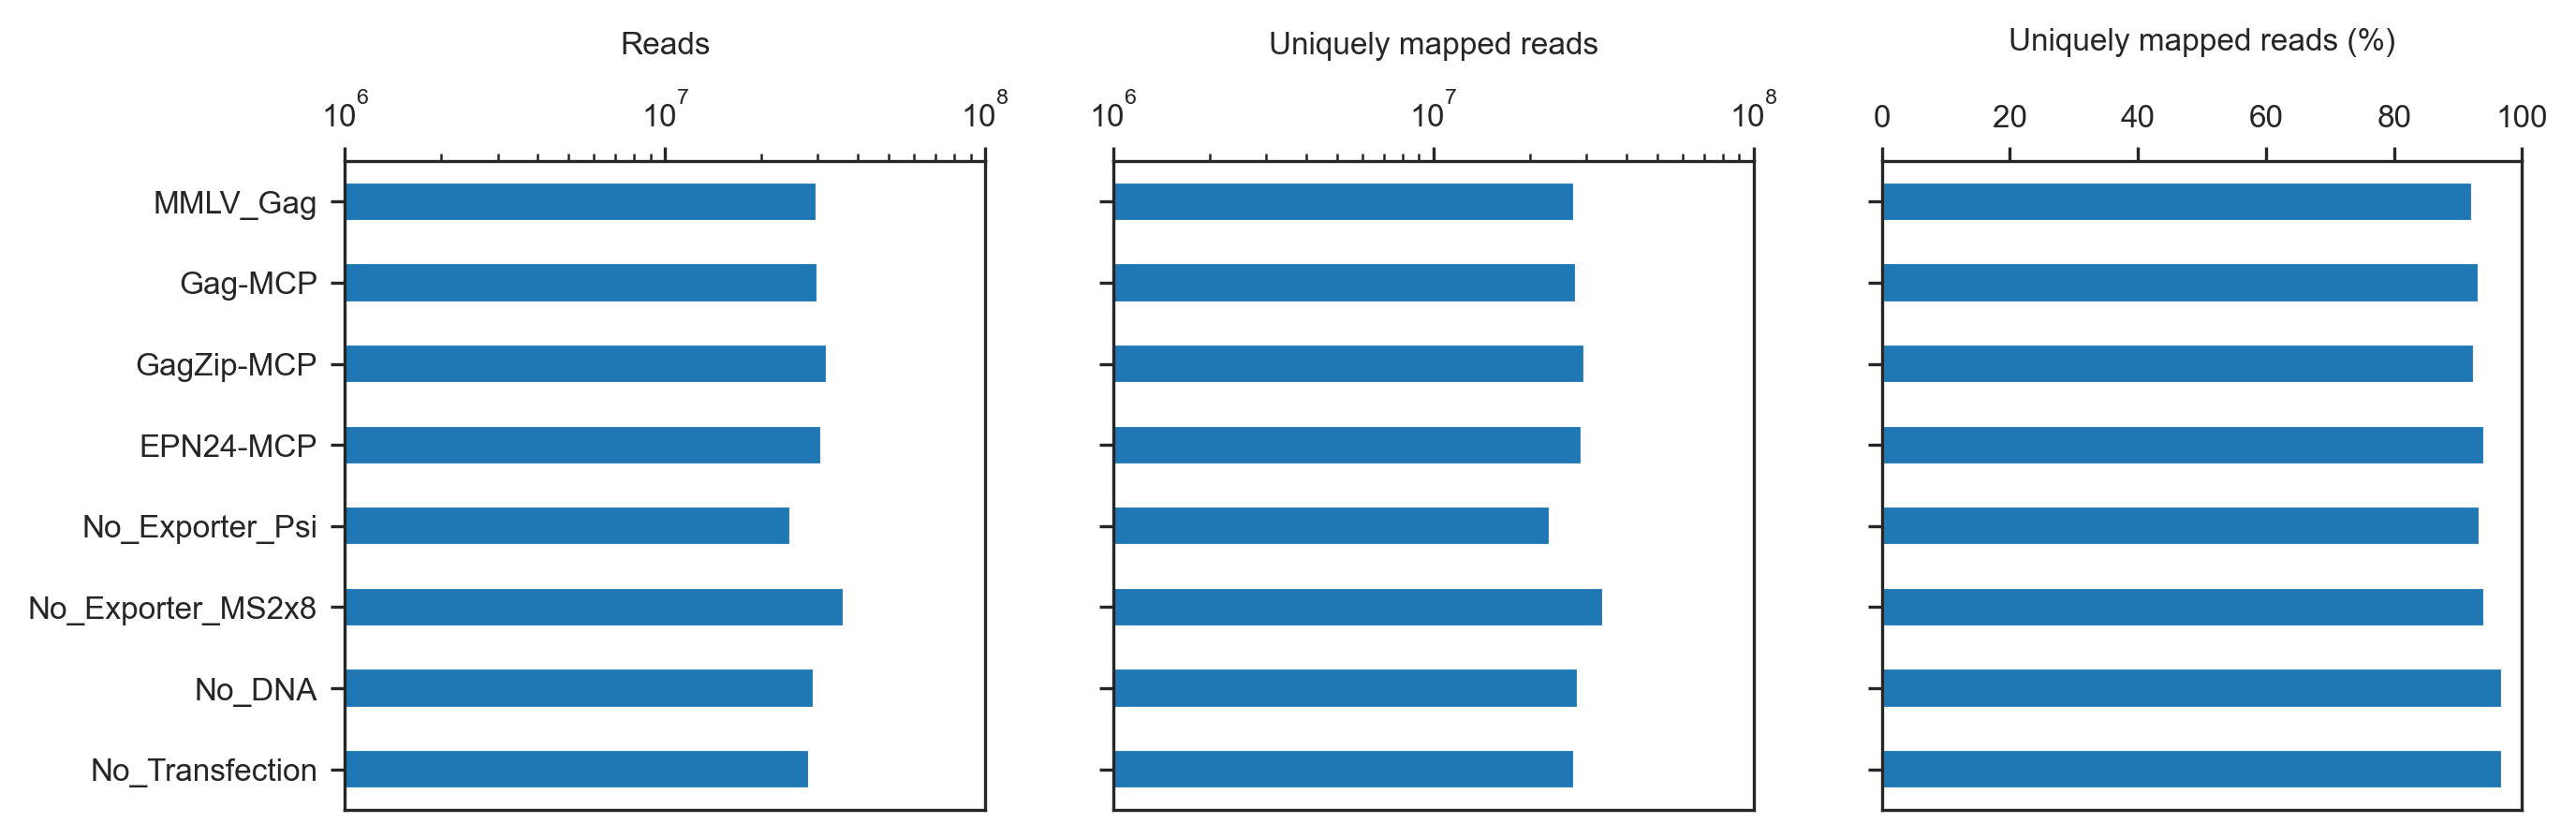

In [17]:
fig, axes = plt.subplots(1, 3, figsize=(10,3), sharey=True)

ax = axes[0]
star_raw.input.plot(ax=ax, kind="barh", log=True)
ax.invert_yaxis()
ax.set_xscale("log")
ax.set_xlim(1e6, 1e8)
ax.xaxis.tick_top()
ax.set_xlabel("Reads", labelpad=10)
ax.xaxis.set_label_position('top')
ax.set_ylabel("")

ax = axes[1]
star_raw.uniquely_mapped.plot(ax=ax, kind="barh")
ax.invert_yaxis()
ax.set_xscale("log")
ax.set_xlim(1e6, 1e8)
ax.xaxis.tick_top()
ax.set_xlabel("Uniquely mapped reads", labelpad=10)
ax.xaxis.set_label_position('top') 

ax = axes[2]
star_raw.percent_uniquely_mapped.plot(ax=ax, kind="barh")
ax.invert_yaxis()
ax.set_xlim(0, 100)
ax.xaxis.tick_top()
ax.set_xlabel("Uniquely mapped reads (%)", labelpad=14)
ax.xaxis.set_label_position('top')

# Differential expression analysis

To analyze differential expression, we use DESeq2 in R. To achieve this, we export the data to temporary files. In an auxilliary notebook running in R, we import the data, run DESeq2, then export the results. Finally, we import the results and analyze and visualize them here.

## Export data to temporary files

In [18]:
# Define metadata

metadata = pd.DataFrame(index=counts.columns)

metadata["color"] = [sample_to_color[x] for x in metadata.index]
metadata["color"] = pd.Categorical(metadata["color"])  # convert to categorical

metadata["label"] = metadata.index
metadata["label"] = pd.Categorical(metadata["label"])  # convert to categorical

metadata

,color,label
MMLV_Gag,#3c955b,MMLV_Gag
Gag-MCP,#a29fc2,Gag-MCP
GagZip-MCP,#7b74aa,GagZip-MCP
EPN24-MCP,#563583,EPN24-MCP
No_Exporter_Psi,#fcd0a2,No_Exporter_Psi
No_Exporter_MS2x8,#f68c3f,No_Exporter_MS2x8
No_DNA,#8a8c8f,No_DNA
No_Transfection,#c5c6c8,No_Transfection


In [19]:
# Clean data

counts_clean_for_diffexpr = counts_raw.copy()  # copy the raw counts (not normalized for read count, not transformed)
counts_clean_for_diffexpr = counts_clean_for_diffexpr.drop(names_unmapped)  # drop symbols related to mapping

# Clean column names
col_to_clean_col = {"MMLV_Gag": "Gag",
                    "Gag-MCP": "GagMCP",
                    "GagZip-MCP": "GagZipMCP",
                    "EPN24-MCP": "EPN24MCP",
                    "No_Exporter_Psi": "No_Exporter_Psi",
                    "No_Exporter_MS2x8": "No_Exporter_MS2x8",
                    "No_DNA": "NoDNA",
                    "No_Transfection": "Wildtype"}
counts_clean_for_diffexpr = counts_clean_for_diffexpr.rename(mapper=col_to_clean_col, axis=1)

print(counts_clean_for_diffexpr.shape)
counts_clean_for_diffexpr.head()

(30877, 8)


,Gag,GagMCP,GagZipMCP,EPN24MCP,No_Exporter_Psi,No_Exporter_MS2x8,NoDNA,Wildtype
symbol_ensembl,,,,,,,,
EGFP,198592,98788,93438,62364,0,0,0,0
TSPAN6_ENSG00000000003,2691,2615,2802,2800,2464,3358,3184,2991
TNMD_ENSG00000000005,7,2,8,7,5,8,10,11
DPM1_ENSG00000000419,1514,1543,1533,1536,1263,1936,1291,1139
SCYL3_ENSG00000000457,535,614,653,625,522,686,614,557


In [20]:
# Create clean metadata

metadata_clean_for_diffexpr = metadata.copy()  # copy metadata
metadata_clean_for_diffexpr = metadata_clean_for_diffexpr.drop(["color"], axis=1)

# Set conditions
metadata_clean_for_diffexpr["condition_transfected"] = ["transfected", "transfected", "transfected", "transfected",
                                                        "transfected", "transfected", "untransfected", "untransfected"]
metadata_clean_for_diffexpr["condition_exporter_indiv_no_exporter_pool"] = ["exporter_Gag", "exporter_GagMCP", "exporter_GagZipMCP", "exporter_EPN24MCP",
                                                                            "no_exporter", "no_exporter", "untransfected", "untransfected"]
metadata_clean_for_diffexpr["condition_exporter_indiv_no_exporter_indiv"] = ["exporter_Gag", "exporter_GagMCP", "exporter_GagZipMCP", "exporter_EPN24MCP",
                                                                             "no_exporter_Psi", "no_exporter_MS2", "untransfected", "untransfected"]
metadata_clean_for_diffexpr["condition_null"] = ["exporter_Gag", "exporter_GagMCP", "exporter_GagZipMCP", "exporter_EPN24MCP",
                                                 "no_exporter_Psi", "no_exporter_MS2", "no_DNA", "no_transfection"]
metadata_clean_for_diffexpr["condition_exporter"] = ["exporter", "exporter", "exporter", "exporter",
                                                     "no_exporter", "no_exporter", "no_exporter", "no_exporter"]

# Clean row names
metadata_clean_for_diffexpr = metadata_clean_for_diffexpr.rename(mapper=col_to_clean_col, axis=0)

# Set additional condition of clean labels (because R is dumb)
metadata_clean_for_diffexpr["label_clean"] = metadata_clean_for_diffexpr.index

print(metadata_clean_for_diffexpr.shape)
metadata_clean_for_diffexpr

(8, 7)


,label,condition_transfected,condition_exporter_indiv_no_exporter_pool,condition_exporter_indiv_no_exporter_indiv,condition_null,condition_exporter,label_clean
Gag,MMLV_Gag,transfected,exporter_Gag,exporter_Gag,exporter_Gag,exporter,Gag
GagMCP,Gag-MCP,transfected,exporter_GagMCP,exporter_GagMCP,exporter_GagMCP,exporter,GagMCP
GagZipMCP,GagZip-MCP,transfected,exporter_GagZipMCP,exporter_GagZipMCP,exporter_GagZipMCP,exporter,GagZipMCP
EPN24MCP,EPN24-MCP,transfected,exporter_EPN24MCP,exporter_EPN24MCP,exporter_EPN24MCP,exporter,EPN24MCP
No_Exporter_Psi,No_Exporter_Psi,transfected,no_exporter,no_exporter_Psi,no_exporter_Psi,no_exporter,No_Exporter_Psi
No_Exporter_MS2x8,No_Exporter_MS2x8,transfected,no_exporter,no_exporter_MS2,no_exporter_MS2,no_exporter,No_Exporter_MS2x8
NoDNA,No_DNA,untransfected,untransfected,untransfected,no_DNA,no_exporter,NoDNA
Wildtype,No_Transfection,untransfected,untransfected,untransfected,no_transfection,no_exporter,Wildtype


In [21]:
%%time

# Export counts and metadata

outfile = output_dir + "/counts_clean_for_differential_expression.tsv"
counts_clean_for_diffexpr.to_csv(outfile, sep="\t")

outfile = output_dir + "/metadata_clean_for_differential_expression.tsv"
metadata_clean_for_diffexpr.to_csv(outfile, sep="\t")

CPU times: user 65.7 ms, sys: 3.04 ms, total: 68.7 ms
Wall time: 67.7 ms


## Run differential expression analysis in helper notebook

Helper notebook name is `transcriptome_stress_helper.ipynb`.

## Import results

In [22]:
# Set names and files

infiles_de = {"Gag_vs_no_exporter": "differential_expression_result_Gag_vs_no_exporter.csv",
              "GagMCP_vs_no_exporter": "differential_expression_result_GagMCP_vs_no_exporter.csv",
              "GagZipMCP_vs_no_exporter": "differential_expression_result_GagZipMCP_vs_no_exporter.csv",
              "EPN24MCP_vs_no_exporter": "differential_expression_result_EPN24MCP_vs_no_exporter.csv"}

In [23]:
# Load results

de = {}

for col, infile_basename in infiles_de.items():
    infile = output_dir + "/" + infile_basename
    df_temp = pd.read_csv(infile, index_col=0)
    de[col] = df_temp

# Plot differential expression analysis

In [24]:
# Define function to make volcano plot

def plot_volcano(x, y, figsize=(1.5,1.5), fig=None, ax=None):
    
    marker_size = 40

    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=figsize)

    ax.scatter(x, y, marker=".", alpha=0.1, color="#666666")
    
    # Show transgenes

    symbol = "mCherry"
    ax.scatter(x.loc[symbol], y.loc[symbol], marker=gene_to_marker[symbol], color=gene_to_color[symbol], s=marker_size, zorder=20)

    symbol = "mTagBFP2"
    ax.scatter(x.loc[symbol], y.loc[symbol], marker=gene_to_marker[symbol], color=gene_to_color[symbol], s=marker_size, zorder=10)

    symbol = "EGFP"
    ax.scatter(x.loc[symbol], y.loc[symbol], marker=gene_to_marker[symbol], color=gene_to_color[symbol], s=marker_size, zorder=30)
    
    ax.set_xlabel("$log_2$ fold change")
    ax.set_ylabel("Significance ($-log_{10}P_{adj}$)")

    return fig, ax

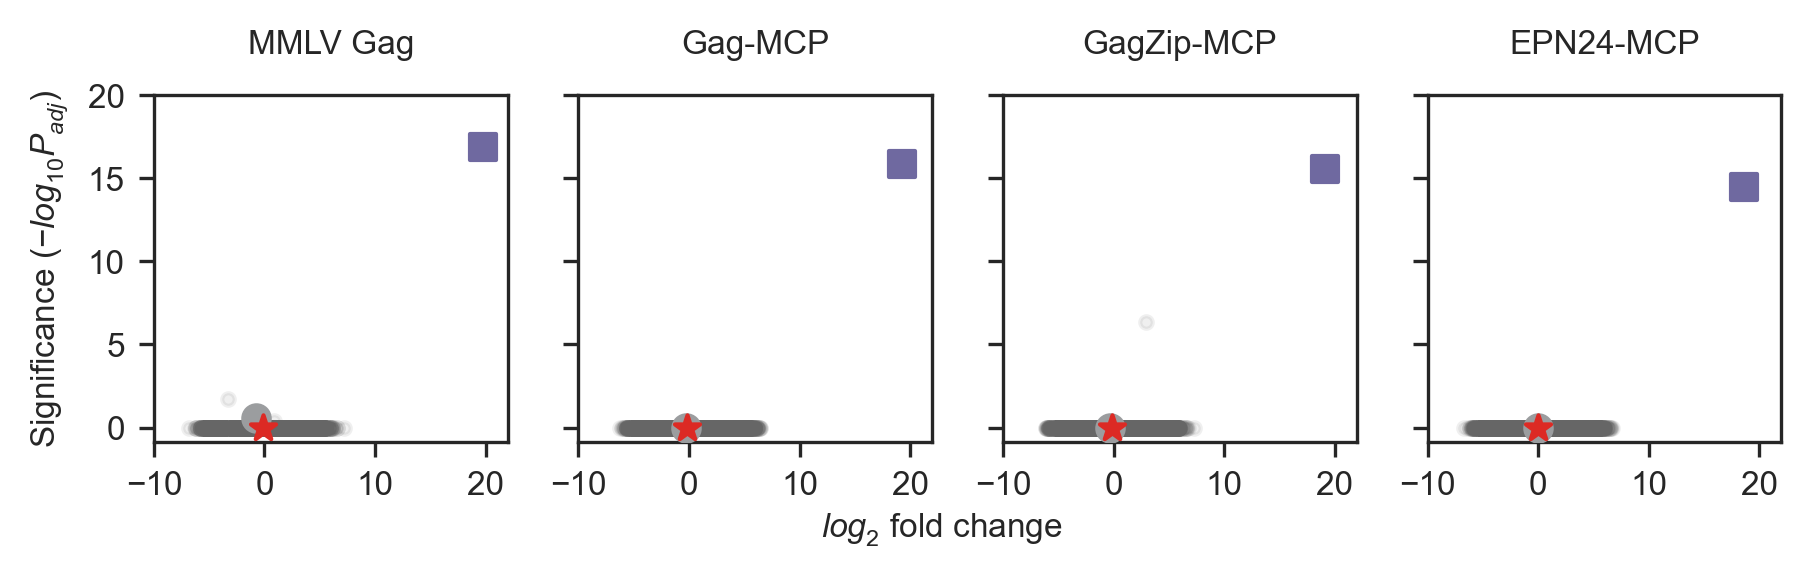

In [25]:
fig, axes = plt.subplots(1, 4, figsize=(7,1.5), sharey=True)

# Gag

ax = axes[0]

label = "Gag_vs_no_exporter"
title = "MMLV Gag"

df = de[label]

x = df["log2FoldChange"]
y = -np.log10(df["padj"])
plot_volcano(x, y, fig=fig, ax=ax)
ax.set_title(title, pad=10)

# Gag-MCP

ax = axes[1]

label = "GagMCP_vs_no_exporter"
title = "Gag-MCP"

df = de[label]

x = df["log2FoldChange"]
y = -np.log10(df["padj"])
plot_volcano(x, y, fig=fig, ax=ax)
ax.set_title(title, pad=10)

# GagZip-MCP

ax = axes[2]

label = "GagZipMCP_vs_no_exporter"
title = "GagZip-MCP"

df = de[label]

x = df["log2FoldChange"]
y = -np.log10(df["padj"])
plot_volcano(x, y, fig=fig, ax=ax)
ax.set_title(title, pad=10)

# EPN24-MCP

ax = axes[3]

label = "EPN24MCP_vs_no_exporter"
title = "EPN24-MCP"

df = de[label]

x = df["log2FoldChange"]
y = -np.log10(df["padj"])
plot_volcano(x, y, fig=fig, ax=ax)
ax.set_title(title, pad=10)

for ax in axes:
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_xticks([-10, 0, 10, 20])
    ax.set_yticks([0, 5, 10, 15, 20])
    ax.set_xlim(right=22)
    
xlabel = "$log_2$ fold change"
fig.text(0.5, -0.1, xlabel, ha="center")
axes[0].set_ylabel("Significance ($-log_{10}P_{adj}$)")

save_figure(fig, "volcano_differential_expression")

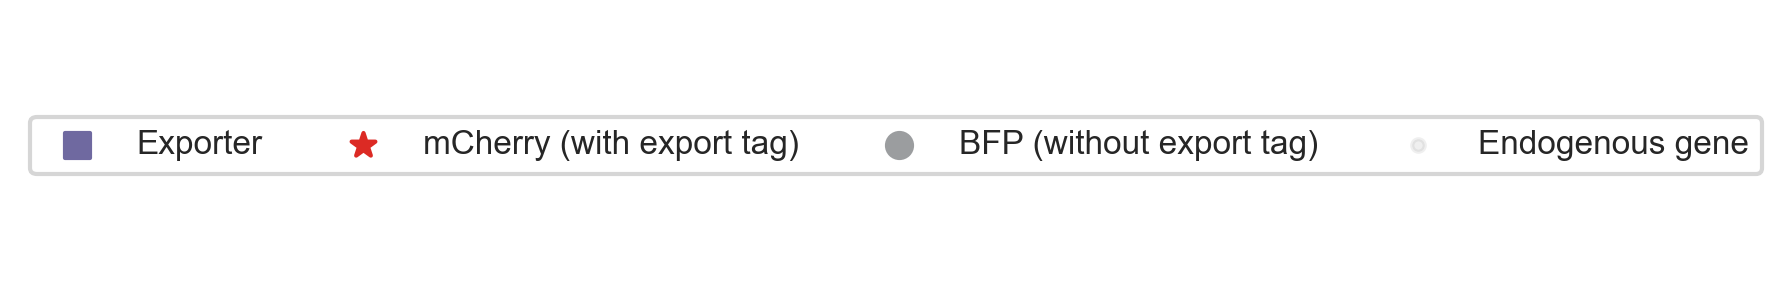

In [26]:
# Plot legend

fig, ax = plt.subplots(1, 1, figsize=(2,1))

symbol = "EGFP"
label = "Exporter"
ax.scatter(0, 0, marker=gene_to_marker[symbol], color=gene_to_color[symbol], label=label)

symbol = "mCherry"
label = "mCherry (with export tag)"
ax.scatter(0, 0, marker=gene_to_marker[symbol], color=gene_to_color[symbol], label=label)

symbol = "mTagBFP2"
label = "BFP (without export tag)"
ax.scatter(0, 0, marker=gene_to_marker[symbol], color=gene_to_color[symbol], label=label)

label = "Endogenous gene"
ax.scatter(0, 0, marker=".", alpha=0.1, color="#666666", label=label)

fig.legend(loc="center", ncol=4)

ax.set_xlim(1,2) 
plt.axis('off')

save_figure(fig, "volcano_differential_expression_legend")

## Examine number of differentially expressed genes

In [27]:
# Show number of differentially expressed genes at P < 0.05

padj_cutoff = 0.05

for label, df in de.items():
    n_genes = np.sum(de[label]["padj"] < padj_cutoff)
    print(label, "\t", n_genes)

Gag_vs_no_exporter 	 2
GagMCP_vs_no_exporter 	 1
GagZipMCP_vs_no_exporter 	 2
EPN24MCP_vs_no_exporter 	 1


In [28]:
# Show number of differentially expressed genes at P < 1e-5

padj_cutoff = 1e-5

for label, df in de.items():
    n_genes = np.sum(de[label]["padj"] < padj_cutoff)
    print(label, "\t", n_genes)

Gag_vs_no_exporter 	 1
GagMCP_vs_no_exporter 	 1
GagZipMCP_vs_no_exporter 	 2
EPN24MCP_vs_no_exporter 	 1


Note that exporter is included in the counts of differentially expressed genes. This accounts for one gene in each case.